# Entendimiento de datos

In [1]:
!pip list 

Package                   Version
------------------------- -----------
asttokens                 3.0.0
attrs                     25.3.0
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.3.1
cycler                    0.12.1
debugpy                   1.8.11
decorator                 5.2.1
et_xmlfile                2.0.0
exceptiongroup            1.2.2
executing                 2.1.0
factor_analyzer           0.5.1
fastjsonschema            2.21.1
fonttools                 4.57.0
imbalanced-learn          0.13.0
importlib_metadata        8.6.1
ipykernel                 6.29.5
ipython                   9.1.0
ipython_pygments_lexers   1.1.1
jedi                      0.19.2
joblib                    1.4.2
jsonschema                4.23.0
jsonschema-specifications 2024.10.1
jupyter_client            8.6.3
jupyter_core              5.7.2
kiwisolver                1.4.8
matplotlib                3.9.2
matplotlib-inline         0.1.7
mkl_fft            

Conjunto de datos utlizado: [CICIDS2017](https://www.unb.ca/cic/datasets/ids-2017.html)

In [1]:
# Importaciones
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Utilidades

In [3]:
# Configuración

# Semilla para reproductibilidad de resultados
seed=9603

# Proporción de la muestra extraída del dataset original para entrenar los modelos de Machine Learning
# dataset_size = 0.217319778
dataset_size = 0.0757828836335171
# Proporción del conjunto de pruebas
test_size = 0.20

# Nombres de carpetas 
carpetas = (
    "MachineLearningCVE",
    "TrafficLabelling"
)
archivos_csv = (
    # "monday", # Los registros del lunes contienen unicamente registros de tráfico normal, por ello no se adjuntará este dataset
    "tuesday",
    "wednesday",
    "thursday_morning_webattacks",
    "thursday_afternoon_infilteration",
    "friday_morning",
    "friday_afternoon_portscan",
    "friday_afternoon_ddos",
)
output_paths = (
    "output/",
    "../3_preparacion_de_datos/DB/"
)

In [4]:
# Utilidades 
# Arrays según el tipo de característica
caracteristicas_nominales = ['destination_port', 'label']

caracteristicas_binarias  = [
      'fwd_psh_flags', 'fwd_urg_flags',
      'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 
      'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 
      'cwe_flag_count', 'ece_flag_count'
]
      
caracteristicas_numericas = [
      'flow_duration', 'total_fwd_packets', 'total_backward_packets', 
      'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 
      'fwd_packet_length_max', 'fwd_packet_length_min', 
      'fwd_packet_length_mean', 'fwd_packet_length_std', 
      'bwd_packet_length_max', 'bwd_packet_length_min', 
      'bwd_packet_length_mean', 'bwd_packet_length_std', 
      'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 
      'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 
      'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 
      'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 
      'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
      'min_packet_length', 'max_packet_length', 'packet_length_mean',
      'packet_length_std', 'packet_length_variance', 'down/up_ratio',
      'average_packet_size', 'avg_fwd_segment_size', 
      'avg_bwd_segment_size', 'fwd_header_length.1', 'subflow_fwd_packets', 
      'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes', 
      'init_win_bytes_forward', 'init_win_bytes_backward', 
      'act_data_pkt_fwd', 'min_seg_size_forward', 'active_mean', 
      'active_std', 'active_max', 'active_min', 'idle_mean', 'idle_std', 
      'idle_max', 'idle_min'
]

caracteristicas_no_utiles = [
      'bwd_psh_flags',
      'bwd_urg_flags', 
      'fwd_avg_bytes/bulk', 'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 
      'bwd_avg_bytes/bulk', 'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate'
]

caracteristicas_con_valor_maximo_infinito = [
      'flow_bytes/s', 'flow_packets/s'
]

In [5]:
# getFrequency(): Función para obtener la distribución de frecuencias de la columna label
def getFrequency(df : pd.DataFrame, caracteristica) :
  frecuencia = df[caracteristica].value_counts()
  porcentaje = df[caracteristica].value_counts(normalize=True) * 100

  tabla_frecuencia = pd.DataFrame({
    "Frecuencia": frecuencia,
    "Frecuencia(%)": porcentaje
  })
  
  tabla_frecuencia["Frecuencia(%)"].round(2)
  
  print(tabla_frecuencia)
  print(df.shape)

In [6]:
# generateBoxplot(): Función para generar boxplot 
def generateBoxplot(x, y, data, save_path) :
  sns.boxplot(x=x, y=y, data=data)

  plt.xlabel(x)
  plt.ylabel(y)
  plt.savefig(save_path)
  plt.show()

In [7]:
# generateCorrMatrix(): Función para generar matriz de correlación
def generateCorrMatrix(data, save_path, title="Matriz de correlación", method="pearson", decimals=2) :
  # Generación de matriz de correlación
  matriz_correlacion = data.corr(method=method).round(decimals=decimals)

  # Generación de mapa de calor para visualizar los datos
  plt.figure(figsize=(52, 39))

  sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(title)
  plt.savefig(save_path)
  plt.show()

## Recopilación de datos iniciales - Carga de datos

In [8]:
# Cargando datos
df = pd.concat(
    [pd.read_csv(f"DB/{carpetas[0]}/{i}.csv", sep=",") for i in archivos_csv],
    ignore_index=True
)

print("Datos cargados")
getFrequency(df, " Label")

Datos cargados
                            Frecuencia  Frecuencia(%)
 Label                                               
BENIGN                         1743179      75.763215
DoS Hulk                        231073      10.043050
PortScan                        158930       6.907522
DDoS                            128027       5.564395
DoS GoldenEye                    10293       0.447361
FTP-Patator                       7938       0.345007
SSH-Patator                       5897       0.256299
DoS slowloris                     5796       0.251910
DoS Slowhttptest                  5499       0.239001
Bot                               1966       0.085448
Web Attack � Brute Force          1507       0.065498
Web Attack � XSS                   652       0.028338
Infiltration                        36       0.001565
Web Attack � Sql Injection          21       0.000913
Heartbleed                          11       0.000478
(2300825, 79)


In [9]:
# Eliminación de datos poco frecuentes en el dataset: "Infiltration", "Web Attack � Sql Injection" y "Heartbleed"
df = df[~df[" Label"].isin([
  # "Web Attack � Brute Force",
  "Infiltration",
  "Web Attack � Sql Injection",
  "Heartbleed"])]
getFrequency(df, " Label")

                          Frecuencia  Frecuencia(%)
 Label                                             
BENIGN                       1743179      75.765455
DoS Hulk                      231073      10.043347
PortScan                      158930       6.907726
DDoS                          128027       5.564560
DoS GoldenEye                  10293       0.447374
FTP-Patator                     7938       0.345017
SSH-Patator                     5897       0.256307
DoS slowloris                   5796       0.251917
DoS Slowhttptest                5499       0.239008
Bot                             1966       0.085450
Web Attack � Brute Force        1507       0.065500
Web Attack � XSS                 652       0.028338
(2300757, 79)


In [10]:
# Guardar en carpeta output
for i in output_paths : 
  df.to_csv(f"{i}dataset.csv", index=False)
print(f"Guardado en las carpetas {output_paths}")

Guardado en las carpetas ('output/', '../3_preparacion_de_datos/DB/')


In [11]:
# Muestreo del dataset para realizar pruebas en el modelo de Machine Learning 
df_vector, df_temp = train_test_split(
  df,
  test_size=1-dataset_size,
  stratify=df[" Label"],
  random_state=seed
)
getFrequency(df_vector, " Label")

                          Frecuencia  Frecuencia(%)
 Label                                             
BENIGN                        132102      75.765240
DoS Hulk                       17511      10.043187
PortScan                       12044       6.907666
DDoS                            9702       5.564445
DoS GoldenEye                    780       0.447358
FTP-Patator                      602       0.345269
SSH-Patator                      447       0.256371
DoS slowloris                    439       0.251782
DoS Slowhttptest                 417       0.239164
Bot                              149       0.085457
Web Attack � Brute Force         114       0.065383
Web Attack � XSS                  50       0.028677
(174357, 79)


In [12]:
# Muestreo del conjunto de entrenamiento y pruebas del dataset
df_train, df_test = train_test_split(
  df_vector,
  test_size=0.2,
  stratify=df_vector[" Label"],
  random_state=seed
) 
print("Dataset de entrenamiento")
getFrequency(df_train, " Label")
print("Dataset de prueba")
getFrequency(df_test, " Label")

Dataset de entrenamiento
                          Frecuencia  Frecuencia(%)
 Label                                             
BENIGN                        105681      75.765136
DoS Hulk                       14009      10.043374
PortScan                        9635       6.907553
DDoS                            7761       5.564039
DoS GoldenEye                    624       0.447360
FTP-Patator                      482       0.345557
SSH-Patator                      358       0.256658
DoS slowloris                    351       0.251640
DoS Slowhttptest                 334       0.239452
Bot                              119       0.085314
Web Attack � Brute Force          91       0.065240
Web Attack � XSS                  40       0.028677
(139485, 79)
Dataset de prueba
                          Frecuencia  Frecuencia(%)
 Label                                             
BENIGN                         26421      75.765657
DoS Hulk                        3502      10.042441
PortScan

Para agilizar el análisis, en principio, transformaremos las columnas del dataframe y las etiquetas de la columna label a un formato más fácil de recordar y digitar

In [13]:
# Transformación de nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns)
print(f"Total de características: {len(df.columns)}")

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [14]:
# Transformación de nombres de etiquetas de la columna label
df["label"] = df["label"].str.upper().str.replace("� ", "").str.replace(" ", "_").str.replace("-", "_")
print(df["label"].unique())
print(f"Total de etiquetas: {len(df["label"].unique())}")

['BENIGN' 'FTP_PATATOR' 'SSH_PATATOR' 'DOS_SLOWLORIS' 'DOS_SLOWHTTPTEST'
 'DOS_HULK' 'DOS_GOLDENEYE' 'WEB_ATTACK_BRUTE_FORCE' 'WEB_ATTACK_XSS'
 'BOT' 'PORTSCAN' 'DDOS']
Total de etiquetas: 12


## Descripción de datos

El conjunto de datos recopilado utilizó un transformador para convertir todo el tráfico de red en segmentos que resumen la comunicación entre máquina destino y máquina de origen de un formato ".pcap" a ".csv". Este transformador es llamado "CICFlowMeter" o "ISCXFlowMeter" y es utilizado por varios estudios que generan bases de datos útiles para realizar proyectos de ciencia de datos y Machine Learning. El transformador fue programado en el lenguaje Java.

Transformador: [CICFlowMeter]()

### 1. Tipos de datos recolectados

|Tipo|Descripción|
|-|-|
|Flujo|Segmento de red dedicado a la comunicación entre un computador y otro|
|packets|Paquetes envíados durante el flujo|
|IAT|Inter-Arrival Time: tiempo entre la llegada de un paquete y el envío de otro|
|active|Tiempo en el que se están intercambiando paquetes, se considera que está activo el flujo|
|Idle|Tiempo de inactividad en un flujo|
|Subflujo|Segmento del flujo principal que puede surgir cuando hay una interrupción, cortes de actividadm timeouts o solicitudes de reconexión|

### 2. Descripción de características

Existen características a las que se puede identificar cierta relación respecto a la descripción de la característica, sin embargo, su principal diferencia es respecto a la dirección de los datos, ya que en un subflujo existe comunicación de origen a destino (Forward) y de destino a origen (Backward), CICFlowMeter recopila características útiles usando este tipo de enfoque.

A continuación, se describen las características en el dataset.

|Forward|Backward|Tipo de característica|Descripción|
|-|-|-|-|
|total Fwd Packet           |total Bwd packets          |Numérica |Total de paquetes envíados durante el flujo en dirección de bwd/fwd      |
|total Length of Fwd Packet |total Length of Bwd Packet |Numérica |Tamaño total de paquete envíado en dirección de bwd/fwd                  |
|Fwd Packet Length Max      |Bwd Packet Length Max      |Numérica |Tamaño máximo de paquete envíado en dirección de bwd/fwd                 |
|Fwd Packet Length Min      |Bwd Packet Length Min      |Numérica |Tamaño mínimo de paquete envíado e dirección de bwd/fwd                  |
|Fwd Packet Length Mean     |Bwd Packet Length Mean     |Numérica |Tamaño medio de paquete envíado e dirección de bwd/fwd                   |
|Fwd Packet Length Std      |Bwd Packet Length Std      |Numérica |Desviación estándar del tamaño de paquete envíado e dirección de bwd/fwd |
|Fwd IAT Total              |Bwd IAT Total              |Numérica |IAT total en dirección de bwd/fwd                                        |
|Fwd IAT Mean               |Bwd IAT Mean               |Numérica |IAT medio en dirección de bwd/fwd                                        |
|Fwd IAT Std                |Bwd IAT Std                |Numérica |Desviación estándar de IAT en dirección de bwd/fwd                       |
|Fwd IAT Max                |Bwd IAT Max                |Numérica |IAT máximo en dirección de bwd/fwd                                       |
|Fwd IAT Min                |Bwd IAT Min                |Numérica |IAT mínimo en dirección de bwd/fwd                                       |
|Fwd PSH flags              |Bwd PSH Flags              |Binaria  |                                                                         |
|Fwd URG Flags              |Bwd URG Flags              |Binaria  |                                                                         |
|Fwd Header Length          |Bwd Header Length          |Numérica |Tamaño total de las cabeceras en bytes en dirección bwd/fwd              |
|FWD Packets/s              |Bwd Packets/s              |Numérica |Números de paquetes por segundo en dirección bwd/fw                      |
|Fwd Segment Size Avg       |Bwd Segment Size Avg       |Numérica |Tamaño promedio de segmentos TCP en el flujo en dirección bwd/fwd        |
|Fwd Bytes/Bulk Avg         |Bwd Bytes/Bulk Avg         |         |                                                                         |
|Fwd Packet/Bulk Avg        |Bwd Packet/Bulk Avg        |         |                                                                         |
|Fwd Bulk Rate Avg          |Bwd Bulk Rate Avg          |         |                                                                         |
|Subflow Fwd Packets        |Subflow Bwd Packets        |Numérica |Número de paquetes enviados en un subflujo de paquete                    |
|Subflow Fwd Bytes          |Subflow Bwd Bytes          |Numérica |Número de bytes enviados en un subflujo de paquetes                      |
|Fwd Init Win bytes         |Bwd Init Win bytes         |Numérica |Respuesta de tamaño en bytes que puede recibir como respuesta            |
|Fwd Act Data Pkts          |                           |Numérica |Recuento de paquetes con mínimo 1 byte de payload de en la dirección fwd |
|Fwd Seg Size Min           |                           |Numérica |Tamaño mínimo de segmento TCP observado en dirección fwd                 |


|Característica|Tipo de característica|Descripción|
|-|-|-|
|Flow Bytes/s           |Numérica |Número de bytes en un flujo por segundo                        |
|Flow Packets/s         |Numérica |Número de paquetes en un flujo por segundo                     |
|Flow IAT Mean          |Numérica |IAT medio dentro de un flujo                                   |
|Flow IAT Std           |Numérica |Desviación estándar del IAT dentro de un flujo                 |
|Flow IAT Max           |Numérica |IAT máximo dentro de un flujo                                  |
|Flow IAT Min           |Numérica |IAT mínimo dentro de un flujo                                  |
|Packet Length Min      |Numérica |Tamaño mínimo de paquetes dentro de un flujo                   |
|Packet Length Max      |Numérica |Tamaño máximo de paquetes dentro de un flujo                   |
|Packet Length Mean     |Numérica |Tamaño medio de paquetes dentro de un flujo                    |
|Packet Length Std      |Numérica |Desviación estándar del tamaño de paquetes dentro de un flujo  |
|Packet Length Variance |Numérica |Varianza del tamaño de paquetes dentro de un flujo             |
|FIN Flag Count         |Binaria  |                                                               |
|SYN Flag Count         |Binaria  |                                                               |
|RST Flag Count         |Binaria  |                                                               |
|PSH Flag Count         |Binaria  |                                                               |
|ACK Flag Count         |Binaria  |                                                               |
|URG Flag Count         |Binaria  |                                                               |
|CWR Flag Count         |Binaria  |                                                               |
|ECE Flag Count         |Binaria  |                                                               |
|down/Up Ratio          |Numérica |Ratio de carga y descarga                                      |
|Average Packet Size    |Numérica |Tamaño promedio de paquetes en un flujo                        |
|Active Mean            |Numérica |Tiempo activo medio                                            |
|Active Std             |Numérica |Desviación estándar del tiempo activo                          |
|Active Max             |Numérica |Máximo tiempo activo                                           |
|Active Min             |Numérica |Mínimo tiempo activo                                           |
|Idle Mean              |Numérica |Idle medio en un flujo                                         |
|Idle Std               |Numérica |Desviación estándar del Idle en un flujo                       |
|Idle Max               |Numérica |Idle máximo en un flujo                                        |
|Idle Min               |Numérica |Idle mínimo en un flujo                                        |
|destination_port       |Nominal  |Puerto de destino                                              |
|label                  |Nominal  |variable objetivo (Tipo de ciberataque)                        |

### 3. Distribución de datos

In [15]:
# Visualización de características y tipo de datos
distribucion = df.shape
print(f"""
N° registros: {distribucion[0]}
N° características: {distribucion[1]}
""")
print(f"""
{df.dtypes.head(40)}
{df.dtypes.tail(40)}
""")


N° registros: 2300757
N° características: 79


destination_port                 int64
flow_duration                    int64
total_fwd_packets                int64
total_backward_packets           int64
total_length_of_fwd_packets      int64
total_length_of_bwd_packets      int64
fwd_packet_length_max            int64
fwd_packet_length_min            int64
fwd_packet_length_mean         float64
fwd_packet_length_std          float64
bwd_packet_length_max            int64
bwd_packet_length_min            int64
bwd_packet_length_mean         float64
bwd_packet_length_std          float64
flow_bytes/s                   float64
flow_packets/s                 float64
flow_iat_mean                  float64
flow_iat_std                   float64
flow_iat_max                     int64
flow_iat_min                     int64
fwd_iat_total                    int64
fwd_iat_mean                   float64
fwd_iat_std                    float64
fwd_iat_max                      int64
fwd_iat_min     

## Exploración de datos

### 1. Variable objetivo: label

In [16]:
# Tabla de frecuencia de tipos de ciberataques
getFrequency(df, "label")

                        Frecuencia  Frecuencia(%)
label                                            
BENIGN                     1743179      75.765455
DOS_HULK                    231073      10.043347
PORTSCAN                    158930       6.907726
DDOS                        128027       5.564560
DOS_GOLDENEYE                10293       0.447374
FTP_PATATOR                   7938       0.345017
SSH_PATATOR                   5897       0.256307
DOS_SLOWLORIS                 5796       0.251917
DOS_SLOWHTTPTEST              5499       0.239008
BOT                           1966       0.085450
WEB_ATTACK_BRUTE_FORCE        1507       0.065500
WEB_ATTACK_XSS                 652       0.028338
(2300757, 79)


### 2. Distribución de datos

In [17]:
# Características numéricas
for i in caracteristicas_numericas : 
  print(f"""
  Característica: {i}
{df[i].describe()}
""")


  Característica: flow_duration
count    2.300757e+06
mean     1.579691e+07
std      3.460423e+07
min     -1.300000e+01
25%      1.470000e+02
50%      3.132100e+04
75%      4.578193e+06
max      1.200000e+08
Name: flow_duration, dtype: float64


  Característica: total_fwd_packets
count    2.300757e+06
mean     9.099027e+00
std      7.127143e+02
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      5.000000e+00
max      2.079640e+05
Name: total_fwd_packets, dtype: float64


  Característica: total_backward_packets
count    2.300757e+06
mean     1.011327e+01
std      9.522557e+02
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.846020e+05
Name: total_backward_packets, dtype: float64


  Característica: total_length_of_fwd_packets
count    2.300757e+06
mean     5.472498e+02
std      1.015996e+04
min      0.000000e+00
25%      6.000000e+00
50%      6.000000e+01
75%      1.870000e+02
max      1.290000e+07
Name: total_l

In [18]:
# Características sin datos para análisis
for i in caracteristicas_no_utiles : 
  print(f"""
  Característica: {i}
{df[i].describe()}
""")


  Característica: bwd_psh_flags
count    2300757.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: bwd_psh_flags, dtype: float64


  Característica: bwd_urg_flags
count    2300757.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: bwd_urg_flags, dtype: float64


  Característica: fwd_avg_bytes/bulk
count    2300757.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: fwd_avg_bytes/bulk, dtype: float64


  Característica: fwd_avg_packets/bulk
count    2300757.0
mean           0.0
std            0.0
min            0.0
25%            0.0
50%            0.0
75%            0.0
max            0.0
Name: fwd_avg_packets/bulk, dtype: float64


  Característica: fwd_avg_bulk_rate
count    2300757.0
mean           0.0
std          

In [19]:
# Características con valores máximos en infinito, es necesario realizar una transformación
for i in caracteristicas_con_valor_maximo_infinito : 
  print(f"""
  Característica: {i}
{df[i].describe()}
""")


  Característica: flow_bytes/s
count    2.299463e+06
mean              inf
std               NaN
min     -2.610000e+08
25%      1.182066e+02
50%      4.292274e+03
75%      1.600000e+05
max               inf
Name: flow_bytes/s, dtype: float64


  Característica: flow_packets/s
count    2.300757e+06
mean              inf
std               NaN
min     -2.000000e+06
25%      2.680303e+00
50%      1.091897e+02
75%      2.380952e+04
max               inf
Name: flow_packets/s, dtype: float64



c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
c:\Users\User\anaconda3\envs\ids_thesis\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


### 3. Visualización de datos

#### 3.1. Boxplots de características numéricas

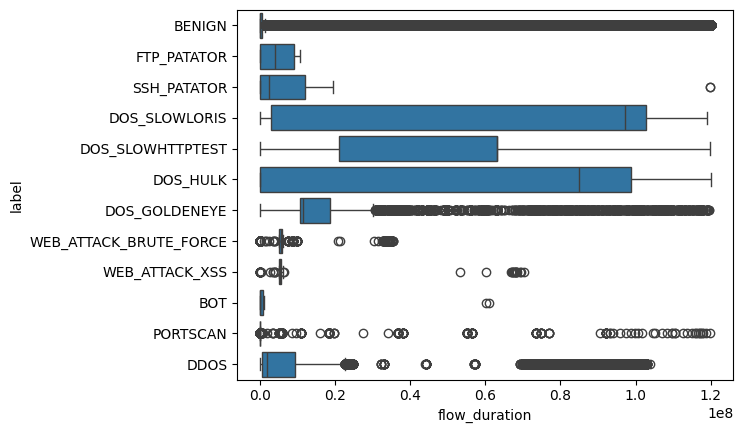

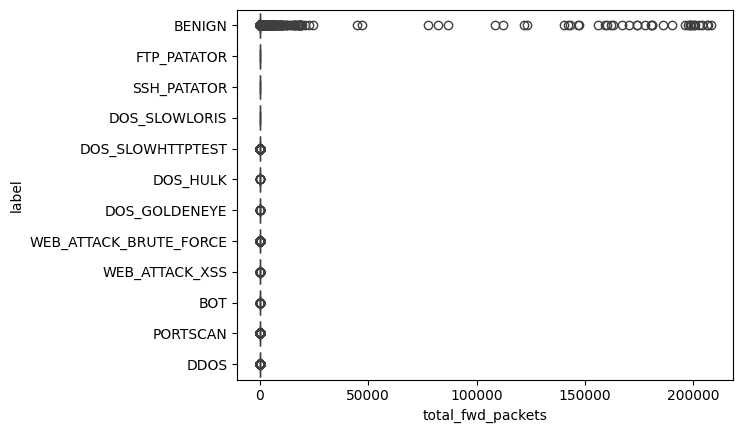

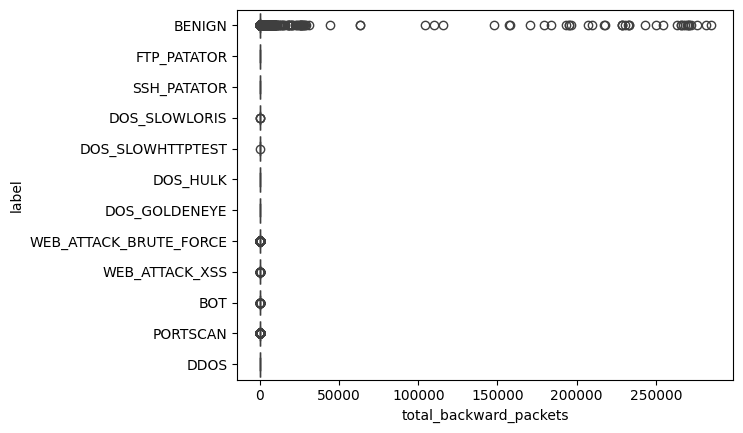

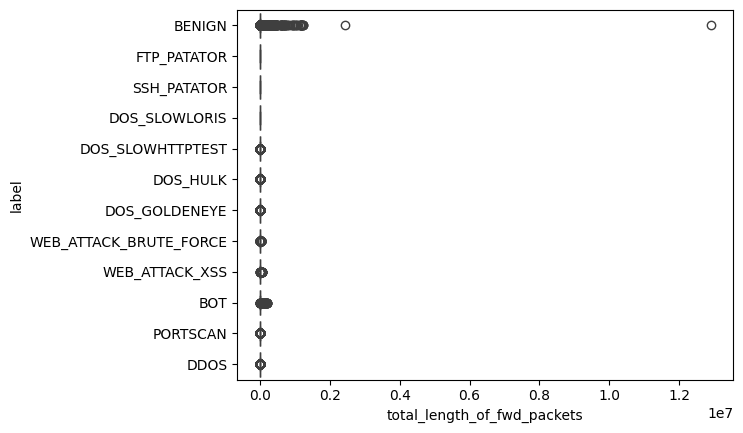

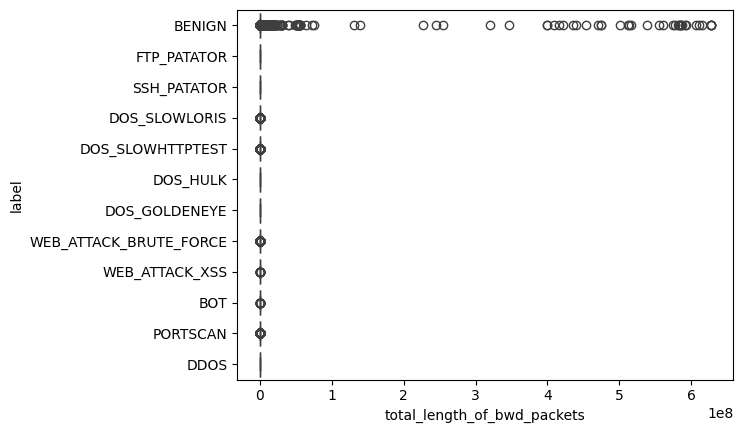

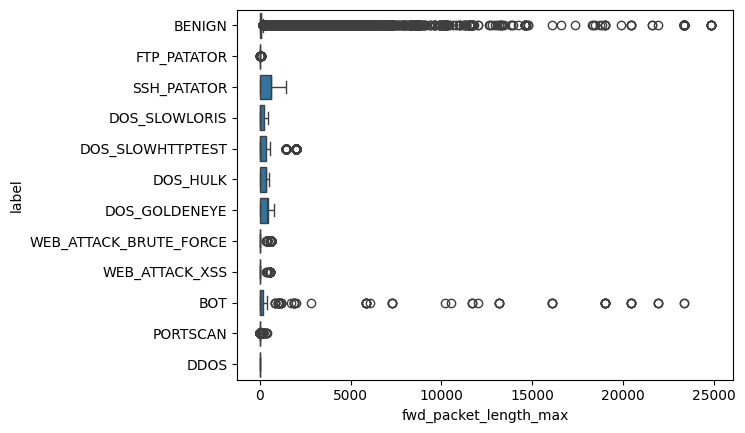

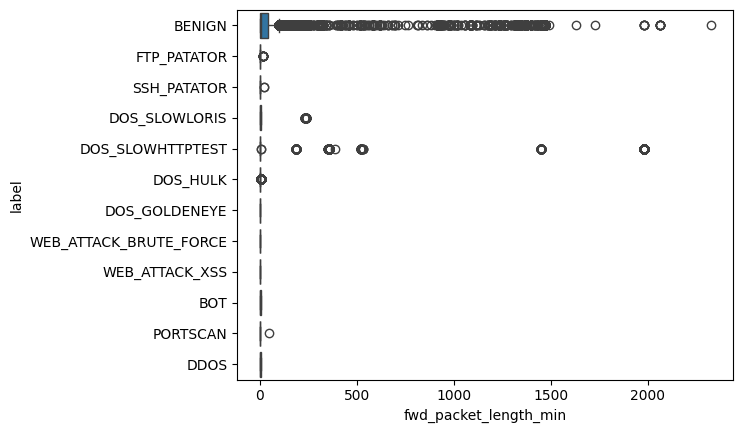

KeyboardInterrupt: 

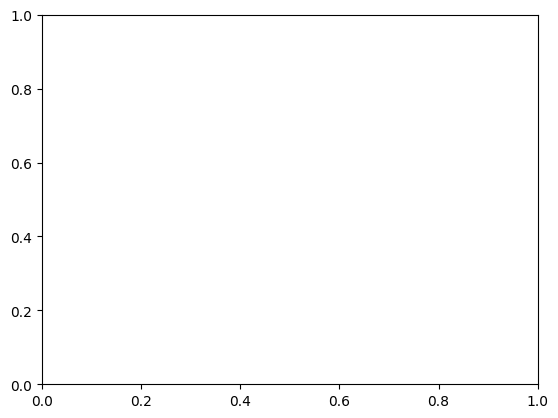

In [20]:
# Los datos tienen bastantes outliers que pueden dificultar el análisis y entrenamiento de modelos de ML
# por ello es necesario establecer un criterio para tratar los outliers
for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito : 
  generateBoxplot(
    x=i,
    y="label",
    data=df,
    save_path=f"img/boxplots/boxplot_label_{i.replace("/","_").replace(".", "_")}"
  )

#### 3.2. Matriz de correlación

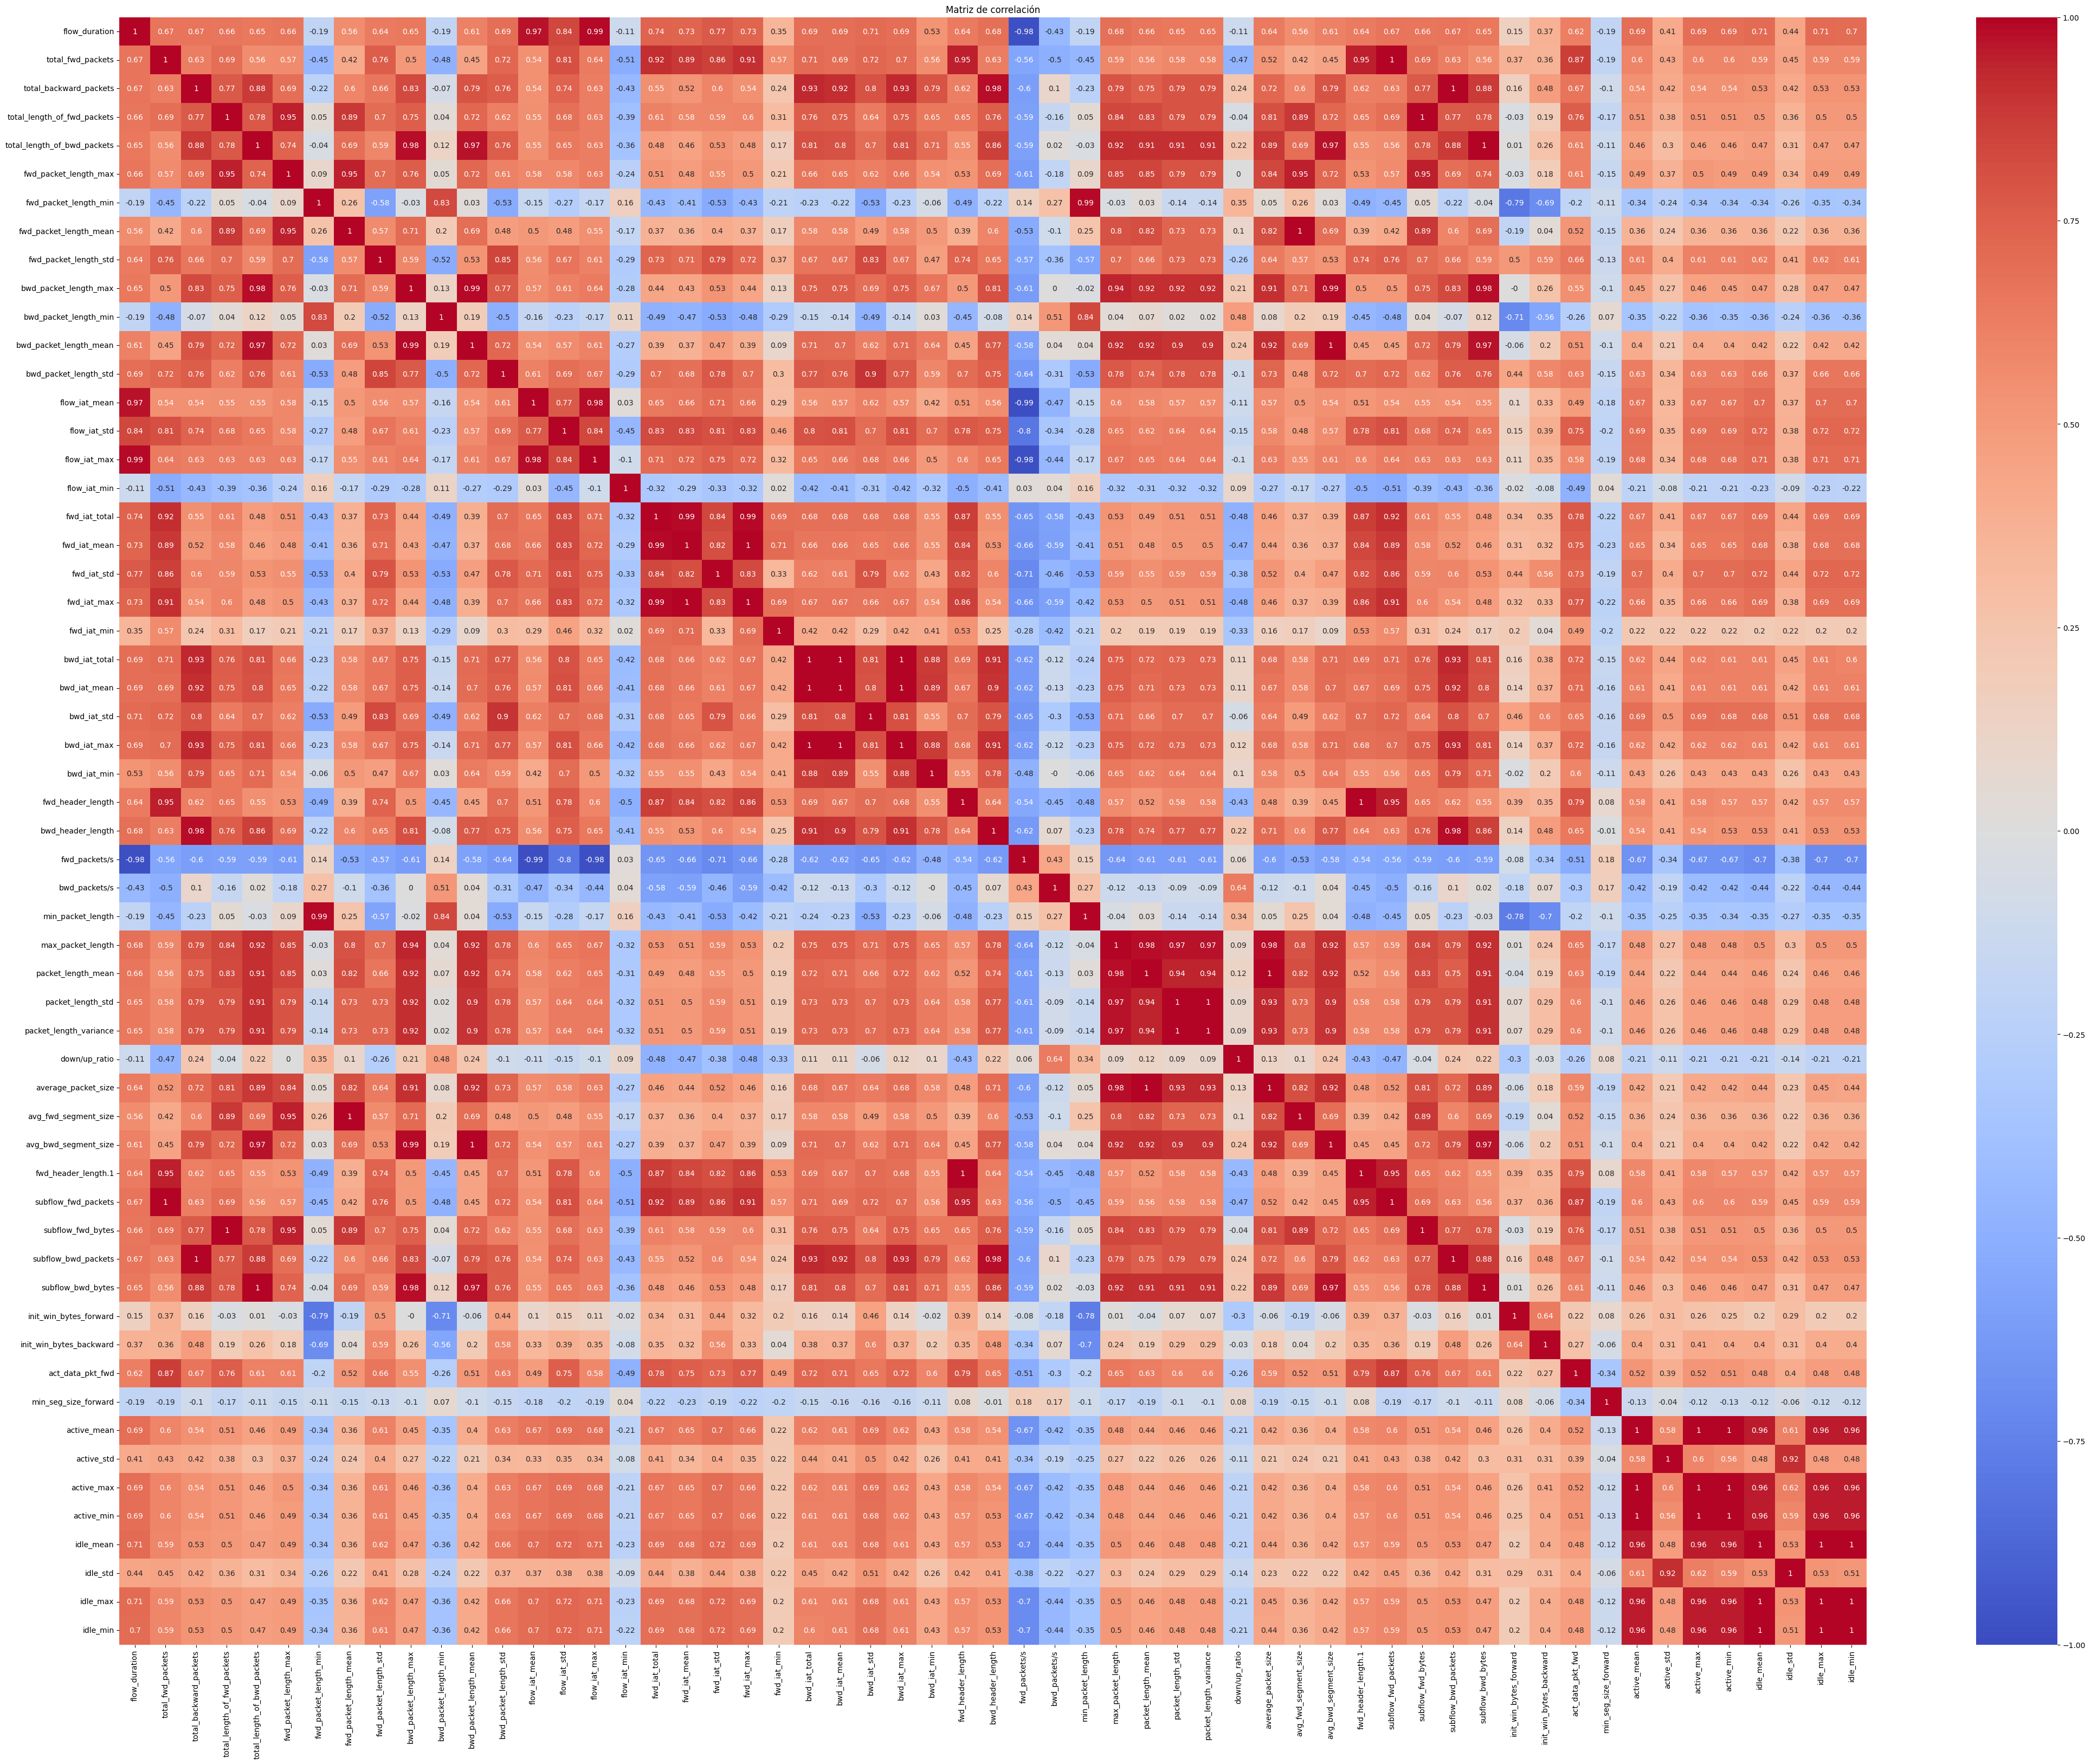

In [ ]:
# Matriz de correlación con test de Spearman sin tratamiento
generateCorrMatrix(
  data=df[caracteristicas_numericas],
  decimals=2,
  save_path="img/matriz_correlacion_pearson_no_normalizada.png",
  method="spearman"
)

## Verificación de calidad de datos

### 1. Revisión de datos nulos

In [ ]:
# La característica flow_bytes/s tiene valores nulos
df.isnull().sum()

destination_port               0
flow_duration                  0
total_fwd_packets              0
total_backward_packets         0
total_length_of_fwd_packets    0
                              ..
idle_mean                      0
idle_std                       0
idle_max                       0
idle_min                       0
label                          0
Length: 79, dtype: int64

### 2. Revisión de datos infinitos

In [ ]:
# Las características flow_bytes/s y flow_packets/s tienen valores infinitos
for i in caracteristicas_numericas + caracteristicas_con_valor_maximo_infinito : 
  cant_inf = df[np.isinf(df[i])].shape[0]
  print(f"Característica: {i} - cant. inf. {cant_inf}")

Característica: flow_duration - cant. inf. 0
Característica: total_fwd_packets - cant. inf. 0
Característica: total_backward_packets - cant. inf. 0
Característica: total_length_of_fwd_packets - cant. inf. 0
Característica: total_length_of_bwd_packets - cant. inf. 0
Característica: fwd_packet_length_max - cant. inf. 0
Característica: fwd_packet_length_min - cant. inf. 0
Característica: fwd_packet_length_mean - cant. inf. 0
Característica: fwd_packet_length_std - cant. inf. 0
Característica: bwd_packet_length_max - cant. inf. 0
Característica: bwd_packet_length_min - cant. inf. 0
Característica: bwd_packet_length_mean - cant. inf. 0
Característica: bwd_packet_length_std - cant. inf. 0
Característica: flow_iat_mean - cant. inf. 0
Característica: flow_iat_std - cant. inf. 0
Característica: flow_iat_max - cant. inf. 0
Característica: flow_iat_min - cant. inf. 0
Característica: fwd_iat_total - cant. inf. 0
Característica: fwd_iat_mean - cant. inf. 0
Característica: fwd_iat_std - cant. inf. 0

### 3. Hipótesis

#### 3.1. Correlación entre flow_packets/s y fwd_packets/s

In [ ]:
# Verificación de correlación entre valores de las columnas flow_packets/s, fwd_packets/s y bwd_packets/s
# Dentro de estos datos están los valores infinitos
df_corr_flow_packets_s = pd.DataFrame(
  np.isclose(df["fwd_packets/s"] + df["bwd_packets/s"], df["flow_packets/s"]),
  columns=["corr"]
)

df_corr_flow_packets_s["flow_packets/s_resto"] = df[~df_corr_flow_packets_s["corr"]]["flow_packets/s"] - df[~df_corr_flow_packets_s["corr"]]["fwd_packets/s"] - df[~df_corr_flow_packets_s["corr"]]["bwd_packets/s"]
flow_packets_s_resto_list = df_corr_flow_packets_s["flow_packets/s_resto"].unique() 

print(df_corr_flow_packets_s["corr"].value_counts())
print("\nDiferencia entre valores de columnas:")
[ print(i) for i in flow_packets_s_resto_list ]

C:\Users\User\AppData\Local\Temp\ipykernel_24248\1770575656.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_corr_flow_packets_s["flow_packets/s_resto"] = df[~df_corr_flow_packets_s["corr"]]["flow_packets/s"] - df[~df_corr_flow_packets_s["corr"]]["fwd_packets/s"] - df[~df_corr_flow_packets_s["corr"]]["bwd_packets/s"]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).